In [3]:
################
#   ZELLE 01   #
################

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score, accuracy_score

from scipy import stats

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
################
#   ZELLE 02   #
################

excel_path = Path("Auswertung_Studie_Nutzungsform_aktualisiert.xlsx")  # ggf. Pfad anpassen
assert excel_path.exists(), f"Datei nicht gefunden: {excel_path.resolve()}"

df_raw = pd.read_excel(excel_path, sheet_name="Final", header=[0, 1])

def flatten_cols(cols):
    out = []
    for a, b in cols:
        a = "" if "Unnamed" in str(a) else str(a).strip()
        b = "" if "Unnamed" in str(b) else str(b).strip()
        name = "_".join([x for x in (a, b) if x])
        out.append(name)
    return out

df = df_raw.copy()
df.columns = flatten_cols(df.columns)

df.head(20)


,Proband Nr.,Ben. Zeit,Kniewinkel 1,Kniewinkel 2,Alter,Geschlecht_weiblich,Geschlecht_männlich,Größe,Beininnenlänge,Sitzhöhe,...,Nutzung Methode_Einstellung durch Laden / Mechaniker,Nutzung Methode_Augenmaß / Gefühl,Nutzung Methode_Hüfte,Gefühl Sitzposition_Deutlich schlechter,Gefühl Sitzposition_Etwas schlechter,Gefühl Sitzposition_Kein Unterschied,Gefühl Sitzposition_Etwas besser,Gefühl Sitzposition_Deutlich besser,Längerer Zeitraum,Veränderungsimpuls
0,25,00:00:35.910000,67.7,157.3,27,x,NaN,164,75.5,70.0,...,NaN,x,NaN,NaN,x,NaN,NaN,NaN,7,1
1,24,00:00:57.040000,68.2,143.1,26,NaN,x,200,92.0,80.0,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,8,1
2,23,00:01:10.400000,75.4,150.6,23,x,NaN,166,79.6,63.5,...,NaN,x,x,NaN,x,NaN,NaN,NaN,2,9
3,22,00:01:15.850000,72.4,161.0,23,x,NaN,172,82.9,71.0,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,9,1
4,21,00:02:19.390000,76.2,160.7,26,x,NaN,178,87.0,76.0,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,10,0
5,20,00:01:39.560000,86.4,148.6,26,NaN,x,193,92.0,77.0,...,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,10,0
6,19,00:01:14.580000,70.8,156.0,21,NaN,x,186,88.0,75.5,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,8,2
7,18,00:02:56.150000,76.6,143.2,26,NaN,x,194,91.0,75.5,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,8,4
8,17,00:02:17.640000,72.6,144.5,27,NaN,x,180,82.0,70.5,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,10,0
9,16,00:01:46.760000,81.3,147.4,23,x,NaN,193,88.0,80.5,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,10,0


In [5]:
# ---------- Helper: Window-Deviation erzeugen ----------
def _fmt_w(v):
    # macht aus 150.0 -> "150", 150.5 -> "150p5"
    v = float(v)
    if abs(v - round(v)) < 1e-9:
        return str(int(round(v)))
    return str(v).replace(".", "p")

def add_window_cols(df, knee_col="Kniewinkel 2", low=150, high=155):
    low, high = float(low), float(high)
    w = f"w{_fmt_w(low)}_{_fmt_w(high)}"

    x = pd.to_numeric(df[knee_col], errors="coerce")
    in_win = ((x >= low) & (x <= high)).astype(int)
    win_dev = np.where(x < low, x - low, np.where(x > high, x - high, 0.0))
    abs_win_dev = np.abs(win_dev)

    df[f"In_{w}"] = in_win
    df[f"WinDev_{w}"] = win_dev
    df[f"AbsWinDev_{w}"] = abs_win_dev
    return f"AbsWinDev_{w}"

def add_target_cols(df, knee_col="Kniewinkel 2", target=152.5):
    x = pd.to_numeric(df[knee_col], errors="coerce")
    df["Dev_Target"] = x - float(target)
    df["AbsDev_Target"] = df["Dev_Target"].abs()
    return "AbsDev_Target"

# ---------- p-Wert: einseitig aus zweiseitig ----------
def p_one_sided(p_two, stat, direction="negative"):
    # direction="negative": H1 stat < 0 ; direction="positive": H1 stat > 0
    if np.isnan(p_two) or np.isnan(stat):
        return np.nan
    if direction == "negative":
        return p_two/2 if stat < 0 else 1 - p_two/2
    else:
        return p_two/2 if stat > 0 else 1 - p_two/2

# =========================================================
# >>> HIER stellst du um, gegen was getestet wird <<<
# =========================================================
KNEE_COL = "Kniewinkel 2"

MODE = "window"      # "window" oder "target"
WINDOW = (150, 155)  # nur für MODE="window"
TARGET = 152.5       # nur für MODE="target"

if MODE == "window":
    YCOL = add_window_cols(df, knee_col=KNEE_COL, low=WINDOW[0], high=WINDOW[1])
elif MODE == "target":
    YCOL = add_target_cols(df, knee_col=KNEE_COL, target=TARGET)
else:
    raise ValueError("MODE muss 'window' oder 'target' sein")

print("Outcome-Spalte:", YCOL)
display(df[[KNEE_COL, YCOL]].head(3))

Outcome-Spalte: AbsWinDev_w150_155


,Kniewinkel 2,AbsWinDev_w150_155
0,157.3,2.3
1,143.1,6.9
2,150.6,0.0


In [6]:
def make_outcome(
    df: pd.DataFrame,
    knee_col: str = "Kniewinkel 2",
    mode: str = "window",
    target: float = 152.5,
    window: tuple[float, float] = (150.0, 155.0),
    signed: bool = False
):
    """
    Erzeugt eine Outcome-Serie "Abweichung" aus dem Kniewinkel.

    mode:
      - "target": Abweichung von target (|x-target| oder signed x-target)
      - "window": Abweichung vom Intervall [low, high] (0 innerhalb, sonst Distanz zur nächsten Grenze)
      - "zscore": z-standardisierte (signed) Abweichung von target (für Skalenvergleich)

    signed:
      - True: Vorzeichen bleibt (x - reference), False: Betrag/Distanz
    """
    x = pd.to_numeric(df[knee_col], errors="coerce")

    if mode == "target":
        dev = x - target
        return dev if signed else dev.abs()

    if mode == "window":
        low, high = window
        if signed:
            # signed: unterhalb negativ, oberhalb positiv, innen 0
            return np.where(x < low, x - low, np.where(x > high, x - high, 0.0))
        else:
            return np.where(x < low, low - x, np.where(x > high, x - high, 0.0))

    if mode == "zscore":
        dev = x - target
        z = (dev - dev.mean()) / dev.std(ddof=1)
        return z

    raise ValueError("mode muss einer von {'target','window','zscore'} sein.")


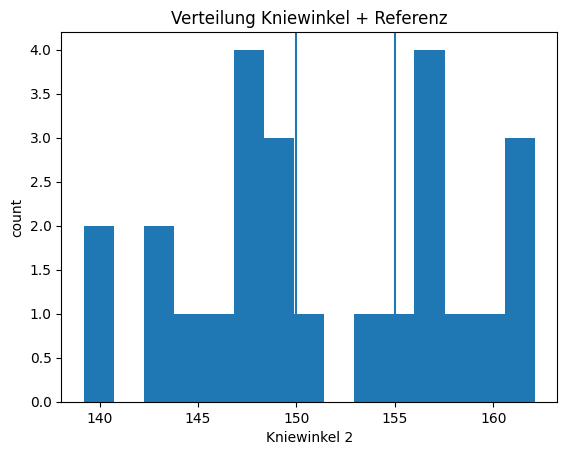

In [7]:
# ==== Outcome-Konfiguration (nur hier umstellen) ====
KNEE_COL = "Kniewinkel 2"

OUTCOME_MODE = "window"     # "window" oder "target"
TARGET = 152.5              # nur relevant für mode="target"
WINDOW = (150.0, 155.0)     # nur relevant für mode="window"
SIGNED = False              # i.d.R. False (Abweichungsbetrag)

# Outcome berechnen
df["Abweichung"] = make_outcome(
    df, knee_col=KNEE_COL,
    mode=OUTCOME_MODE,
    target=TARGET,
    window=WINDOW,
    signed=SIGNED
)


x = pd.to_numeric(df[KNEE_COL], errors="coerce").dropna()

plt.figure()
plt.hist(x, bins=15)
if OUTCOME_MODE == "window":
    plt.axvline(WINDOW[0]); plt.axvline(WINDOW[1])
else:
    plt.axvline(TARGET)
plt.title("Verteilung Kniewinkel + Referenz")
plt.xlabel(KNEE_COL)
plt.ylabel("count")
plt.show()


In [8]:
################
#   ZELLE 03   #
################


# nur echte Datensätze behalten
df = df[df["Proband Nr."].notna()].copy()

# 1) 'x' -> 1 (nur wo es vorkommt)
df = df.replace({"x": 1})

# 2) nur object-Spalten versuchen zu numerifizieren (ohne errors="ignore")
obj_cols = [c for c in df.columns if c != "Proband Nr." and df[c].dtype == "object"]
for c in obj_cols:
    try:
        df[c] = pd.to_numeric(df[c])
    except (ValueError, TypeError):
        # bleibt Text, falls wirklich Text vorhanden ist
        pass

# 3) Ben. Zeit (falls vorhanden) robust in Sekunden umrechnen
if "Ben. Zeit" in df.columns:
    df["Ben. Zeit"] = pd.to_timedelta(df["Ben. Zeit"].astype(str), errors="coerce").dt.total_seconds()

# 4) fehlende Werte auffüllen (nach Konvertierung!)
df = df.fillna(0)

# optional: falls pandas noch object dtypes hat, sauber inferieren
df = df.infer_objects(copy=False)

df.shape
df.head(3)


C:\Users\Marlon\AppData\Local\Temp\ipykernel_19676\1127331608.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"x": 1})


,Proband Nr.,Ben. Zeit,Kniewinkel 1,Kniewinkel 2,Alter,Geschlecht_weiblich,Geschlecht_männlich,Größe,Beininnenlänge,Sitzhöhe,...,Gefühl Sitzposition_Etwas schlechter,Gefühl Sitzposition_Kein Unterschied,Gefühl Sitzposition_Etwas besser,Gefühl Sitzposition_Deutlich besser,Längerer Zeitraum,Veränderungsimpuls,In_w150_155,WinDev_w150_155,AbsWinDev_w150_155,Abweichung
0,25,35.91,67.7,157.3,27,1.0,0.0,164,75.5,70.0,...,1.0,0.0,0.0,0.0,7,1,0,2.3,2.3,2.3
1,24,57.04,68.2,143.1,26,0.0,1.0,200,92.0,80.0,...,0.0,1.0,0.0,0.0,8,1,0,-6.9,6.9,6.9
2,23,70.40,75.4,150.6,23,1.0,0.0,166,79.6,63.5,...,1.0,0.0,0.0,0.0,2,9,1,0.0,0.0,0.0


In [9]:

################
#   ZELLE 04   #
################


# Zielwert (Mitte des 150–155 Fensters)
TARGET = 152.5

# mehrere Fenster, damit du Sensitivität berichten kannst
WINDOWS = {
    "w150_155": (150.0, 155.0),
    "w145_155": (145.0, 155.0),
    "w145_160": (145.0, 160.0),
}

# Haupt-Outcomes
df["AbsDev_Target"] = (df["Kniewinkel 2"] - TARGET).abs()

# Abweichung zum Fenster (0 wenn drin, sonst Distanz zum nächsten Rand, mit Vorzeichen optional)
def window_deviation(x, lo, hi):
    # signed deviation to nearest boundary (0 inside)
    if x < lo: return x - lo
    if x > hi: return x - hi
    return 0.0

for key, (lo, hi) in WINDOWS.items():
    df[f"In_{key}"] = ((df["Kniewinkel 2"] >= lo) & (df["Kniewinkel 2"] <= hi)).astype(int)
    df[f"WinDev_{key}"] = df["Kniewinkel 2"].apply(lambda v: window_deviation(v, lo, hi))
    df[f"AbsWinDev_{key}"] = df[f"WinDev_{key}"].abs()

df[["Kniewinkel 2", "AbsDev_Target"] + [f"In_{k}" for k in WINDOWS]].head()


,Kniewinkel 2,AbsDev_Target,In_w150_155,In_w145_155,In_w145_160
0,157.3,4.8,0,0,1
1,143.1,9.4,0,0,0
2,150.6,1.9,1,1,1
3,161.0,8.5,0,0,0
4,160.7,8.2,0,0,0


In [10]:

################
#   ZELLE 05   #
################


cols = [
    'Fahrradtyp_E-Bike',
    'Fahrradtyp_Trecking',
    'Fahrradtyp_Crosscountry',
    'Fahrradtyp_Sonstige'
]

df['Fahrradtyp_Sonstige'] = df[cols].max(axis=1).astype(int)


print(df[cols].head(5))

df = df.drop(columns=[
    'Fahrradtyp_E-Bike',
    'Fahrradtyp_Trecking',
    'Fahrradtyp_Crosscountry'
])

   Fahrradtyp_E-Bike  Fahrradtyp_Trecking  Fahrradtyp_Crosscountry  \
0                0.0                  0.0                      0.0   
1                0.0                  0.0                      0.0   
2                0.0                  0.0                      0.0   
3                0.0                  0.0                      0.0   
4                0.0                  0.0                      0.0   

   Fahrradtyp_Sonstige  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  


In [11]:
# 1) Spaltennamen + Datentypen + Beispielwerte
import pandas as pd
import numpy as np

print("df shape:", df.shape)
display(df.head(3))

# dtypes
display(pd.DataFrame({"col": df.columns, "dtype": df.dtypes.astype(str)}))

# NA-Anteile
na = df.isna().mean().sort_values(ascending=False)
display(na.head(30))

# Für alle object-Spalten: häufigste Werte (zeigt mir Checkboxen, Kategorien etc.)
obj_cols = df.select_dtypes(include="object").columns.tolist()
for c in obj_cols:
    vc = df[c].astype(str).str.strip().replace({"": np.nan}).value_counts(dropna=False).head(8)
    print("\n---", c, "---")
    print(vc)


df shape: (25, 63)


,Proband Nr.,Ben. Zeit,Kniewinkel 1,Kniewinkel 2,Alter,Geschlecht_weiblich,Geschlecht_männlich,Größe,Beininnenlänge,Sitzhöhe,...,WinDev_w150_155,AbsWinDev_w150_155,Abweichung,AbsDev_Target,In_w145_155,WinDev_w145_155,AbsWinDev_w145_155,In_w145_160,WinDev_w145_160,AbsWinDev_w145_160
0,25,35.91,67.7,157.3,27,1.0,0.0,164,75.5,70.0,...,2.3,2.3,2.3,4.8,0,2.3,2.3,1,0.0,0.0
1,24,57.04,68.2,143.1,26,0.0,1.0,200,92.0,80.0,...,-6.9,6.9,6.9,9.4,0,-1.9,1.9,0,-1.9,1.9
2,23,70.40,75.4,150.6,23,1.0,0.0,166,79.6,63.5,...,0.0,0.0,0.0,1.9,1,0.0,0.0,1,0.0,0.0


,col,dtype
Proband Nr.,Proband Nr.,int64
Ben. Zeit,Ben. Zeit,float64
Kniewinkel 1,Kniewinkel 1,float64
Kniewinkel 2,Kniewinkel 2,float64
Alter,Alter,int64
...,...,...
WinDev_w145_155,WinDev_w145_155,float64
AbsWinDev_w145_155,AbsWinDev_w145_155,float64
In_w145_160,In_w145_160,int32
WinDev_w145_160,WinDev_w145_160,float64


Proband Nr.                                             0.0
Gefühl Sitzposition_Kein Unterschied                    0.0
Methode bekannt_Formeln / Berechnung nach Beinlänge     0.0
Methode bekannt_Fersenmethode                           0.0
Methode bekannt_Kniewinkel                              0.0
Methode bekannt_Hüfte                                   0.0
Methode bekannt_keine                                   0.0
Nutzung Methode_Formeln / Berechnung nach Beinlänge     0.0
Nutzung Methode_Fersenmethode                           0.0
Nutzung Methode_Kniewinkel                              0.0
Nutzung Methode_Einstellung durch Laden / Mechaniker    0.0
Nutzung Methode_Augenmaß / Gefühl                       0.0
Nutzung Methode_Hüfte                                   0.0
Gefühl Sitzposition_Deutlich schlechter                 0.0
Gefühl Sitzposition_Etwas schlechter                    0.0
Gefühl Sitzposition_Etwas besser                        0.0
Zuverlässigkeit                         

Welch t-test (zweiseitig): t=-0.3830, p=0.708145
Means: {'weiblich': 3.299999999999997, 'männlich': 3.7578947368421054} | n: {'weiblich': 6, 'männlich': 19}


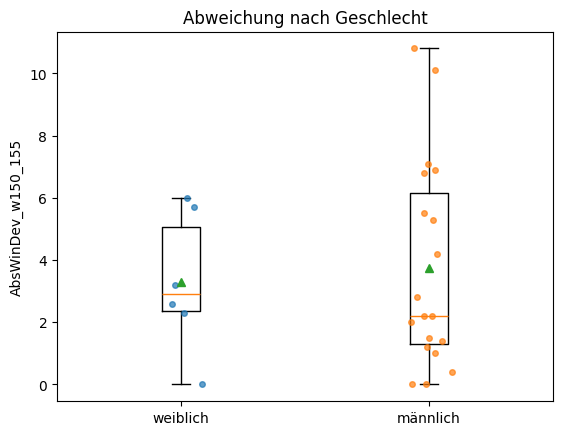

In [12]:
################
# HYPOTHESE 01 #
################

sub = df[[YCOL, "Geschlecht_weiblich", "Geschlecht_männlich"]].dropna()
sub = sub[(sub["Geschlecht_weiblich"] + sub["Geschlecht_männlich"]) == 1]

sub["Geschlecht"] = np.where(sub["Geschlecht_weiblich"] == 1, "weiblich", "männlich")
w = sub.loc[sub["Geschlecht"]=="weiblich", YCOL]
m = sub.loc[sub["Geschlecht"]=="männlich", YCOL]

t, p = stats.ttest_ind(w, m, equal_var=False)
print(f"Welch t-test (zweiseitig): t={t:.4f}, p={p:.6f}")
print("Means:", {"weiblich": w.mean(), "männlich": m.mean()}, "| n:", {"weiblich": len(w), "männlich": len(m)})

plt.figure()
plt.boxplot([w.values, m.values], labels=["weiblich","männlich"], showmeans=True)
for i, vals in enumerate([w.values, m.values], start=1):
    plt.plot(np.random.normal(i, 0.04, len(vals)), vals, "o", alpha=0.7, markersize=4)
plt.ylabel(YCOL)
plt.title("Abweichung nach Geschlecht")
plt.show()
